In [1]:
# system level
import json
import os
import codecs

import numpy as np

# tensorflow and keras
import tensorflow as tf
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# plotting
from matplotlib import pyplot as plt

#reporting
import reporting as rpt
import diagnostics as dg

Using TensorFlow backend.


In [2]:
dir_test = "mnist/"

f_model = dir_test + "model.json" # model data (architecture)
f_history = dir_test + "history.json" # training history 
f_weights = dir_test + "weights.h5" # weights

In [3]:
#load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape

3


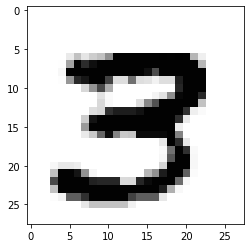

In [7]:
image_index = 111 #You may select anything up to 60,000
print(y_train[image_index]) # The label 
plt.imshow(x_train[image_index], cmap='Greys')

In [4]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [13]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [ ]:
#compiling and saving results
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit (x=x_train,y=y_train, epochs=3)

# Save data
model.save_weights(f_weights, overwrite=True)
open(f_model, 'w').write(model.to_json())

#Saving history for future use
with open(f_history, 'w') as f:
    json.dump(history.history, f)

In [ ]:
#evaluating
score = model.evaluate(x_test, y_test)
image_index = 4444
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

In [5]:
#loading pretrained model and weights
path = 'mnist/history.json'
if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
             n = json.loads(f.read())
                
#loading model
json_file = open(f_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


# load best weights into new model
loaded_model.load_weights(f_weights)
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
10000/10000 [==============================] - 1s 114us/step
accuracy: 98.09%


# Testing using DSUtils functions and reporting

In [15]:
#produce model architecture image and save 
dg.load_plot_model('mnist/model.json')

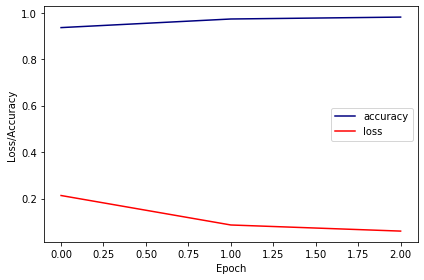

In [9]:
#produce loss/accuracy plot
dg.loss_acc_plot_novalidation(n['loss'], n['acc'])

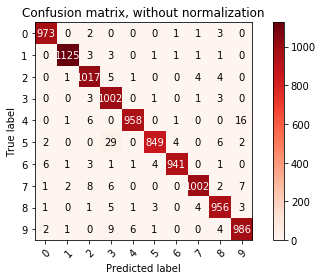

In [6]:
y_pred = loaded_model.predict(x_test)
# convert outputs to predicted number
y_pred_num = np.argmax(y_pred, axis=1)

# produce confusion matrix image
dg.conf_matrix(y_test, y_pred_num, normalize=False, cmap=plt.cm.Reds)

In [8]:
TP = []
TN = []
for i in range(len(y_pred_num)):
    if y_pred_num[i]==y_test[i]:
        TP.append(x_test[i])
    if y_pred_num[i]!=y_test[i]:
        TN.append(x_test[i])
positive = np.stack(TP)
negative = np.stack(TN)
#reshape so we can use it for plotting funciton
positive=positive.reshape(positive.shape[0], 28, 28)
negative=negative.reshape(negative.shape[0], 28, 28)

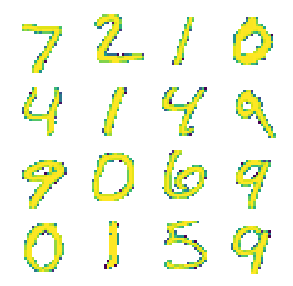

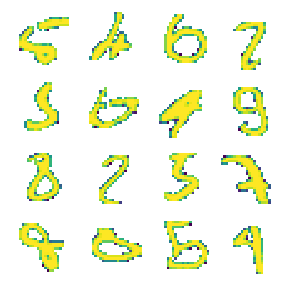

In [9]:
# TP and TN images
dg.examples_plot(positive[:16],4,4,name='TP.pdf') 
dg.examples_plot(negative[:16],4,4,name='TN.pdf') 

In [7]:
# calculate different scores and save them
dg.scores(y_test,y_pred,y_pred_num, avg='weighted', num_classes=10)

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 score: 0.98
Brier score is: 0.03


(0.9809, 0.9811574260593714, 0.9809, 0.9809217996760379, 0.028184594969254892)

# Choose plots and make report

In [1]:
#import plots and data we want to include int the report
import reporting as rpt
rpt.report(examples=True, score=True, lo_acc=True, conf_matrix=True, model=True, name='report_mnist')